## Uni-Modal Text Classifier Base Model

In [1]:
import numpy as np
from sklearn import metrics
import tensorflow
from tensorflow import keras

In [2]:
from utils import data, training, plotting, models_text, optimise_txt

In [3]:
gpus = tensorflow.config.list_physical_devices('GPU')

for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

#### Text Pre-Processing
Load and pre-process text corpus.

In [4]:
label_map = {
    'geol_geow': 0, 
    'geol_sed': 1, 
    'gphys_gen': 2, 
    'log_sum': 3, 
    'pre_site': 4, 
    'vsp_file': 5
}

In [5]:
doc_data = data.DocumentData(label_map, 2020, drop_nans='text')
doc_data.load_text_data()

### Base 1D CNN Classifier
Base 1D CCN text classifier architecture based on the sentence classifier proposed by Kim et al.

##### Test model through a single training cycle:

In [10]:
base_text_cnn = models_text.text_cnn_model(doc_data)

In [11]:
base_text_cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2000)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2000, 150)         23467350  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1997, 100)         60100     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606 

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2, mode='min', 
    restore_best_weights=True
)

history = base_text_cnn.fit(
    doc_data.text_train, 
    doc_data.y_train, 
    epochs=100, 
    validation_data=(doc_data.text_val,  doc_data.y_val), 
    callbacks=[early_stopping]
)

Epoch 1/100


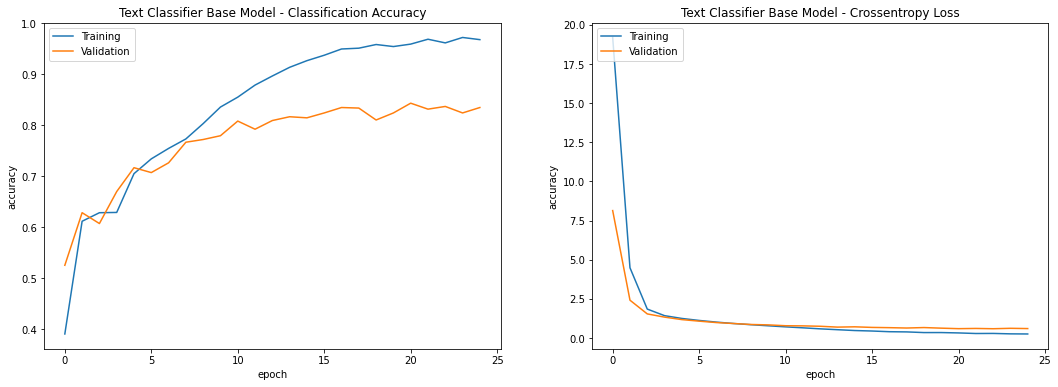

In [9]:
plotting.plot_history(history, 'Text Classifier Base Model')

In [10]:
base_text_cnn.evaluate(doc_data.text_test, doc_data.y_test)

37/37 [==============================] - 1s 25ms/step - loss: 0.6086 - accuracy: 0.8342


[0.6086419820785522, 0.8341836929321289]

In [11]:
y_probs = base_text_cnn.predict(doc_data.text_test)
y_hat = np.argmax(y_probs, axis=-1)

In [9]:
y = np.argmax(doc_data.y_test, axis=-1)

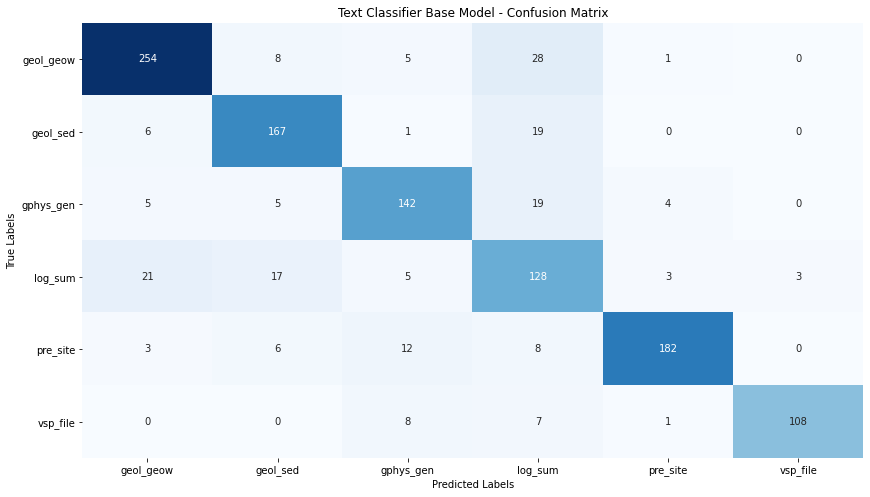

In [13]:
model_utils.confusion_matrix(y, y_hat, label_map, 'Text Classifier Base Model')

In [14]:
labels = [label for label in label_map]
print(metrics.classification_report(y, y_hat, target_names=labels))

              precision    recall  f1-score   support

   geol_geow       0.88      0.86      0.87       296
    geol_sed       0.82      0.87      0.84       193
   gphys_gen       0.82      0.81      0.82       175
     log_sum       0.61      0.72      0.66       177
    pre_site       0.95      0.86      0.91       211
    vsp_file       0.97      0.87      0.92       124

    accuracy                           0.83      1176
   macro avg       0.84      0.83      0.84      1176
weighted avg       0.84      0.83      0.84      1176



##### Get average performance over 10 random initialisations of model:

In [10]:
metric_averages = .iterate_training(models.text_cnn_model, doc_data, 10, y, 'text',  model_params={'doc_data': doc_data})

---- Training model iteration 0:
Epoch 1/100
118/118 - 28s - loss: 18.3941 - accuracy: 0.4435 - val_loss: 7.6814 - val_accuracy: 0.6536
Epoch 2/100
118/118 - 29s - loss: 4.2499 - accuracy: 0.6360 - val_loss: 2.2942 - val_accuracy: 0.6716
Epoch 3/100
118/118 - 29s - loss: 1.7706 - accuracy: 0.6397 - val_loss: 1.4760 - val_accuracy: 0.6599
Epoch 4/100
118/118 - 29s - loss: 1.3793 - accuracy: 0.6520 - val_loss: 1.2793 - val_accuracy: 0.6844
Epoch 5/100
118/118 - 28s - loss: 1.2129 - accuracy: 0.6910 - val_loss: 1.1564 - val_accuracy: 0.6769
Epoch 6/100
118/118 - 28s - loss: 1.0856 - accuracy: 0.7073 - val_loss: 1.0297 - val_accuracy: 0.7513
Epoch 7/100
118/118 - 28s - loss: 0.9800 - accuracy: 0.7503 - val_loss: 0.9521 - val_accuracy: 0.7503
Epoch 8/100
118/118 - 28s - loss: 0.8917 - accuracy: 0.7825 - val_loss: 0.9012 - val_accuracy: 0.7545
Epoch 9/100
118/118 - 28s - loss: 0.8116 - accuracy: 0.8171 - val_loss: 0.8502 - val_accuracy: 0.7726
Epoch 10/100
118/118 - 28s - loss: 0.7462 - accu

In [11]:
metric_averages

{'ave_precision': 0.8346375596692205,
 'ave_recall': 0.826871256755574,
 'ave_f1_score': 0.8285985540849173,
 'ave_accuracy': 0.8261054456233978,
 'ave_loss': 0.622573322057724}

### Hyperparameter Grid Search
Grid search to find optimal hyperparameters for convolutional layer, hyperparameter ranges are based on previous work by Zhang et al, 2016.

In [7]:
filter_regions = (1, 3, 5, 7, 10)
feature_maps = (10, 50, 100, 200, 400, 600)
dropout_rate = (0.1, 0.2, 0.3, 0.4, 0.5)
l2_norm_constraints = (0.5, 1, 2, 3)

In [ ]:
models.text_grid_search(doc_data, filter_regions, feature_maps, dropout_rate, l2_norm_constraints, 'grid_search_logs/text_cnn_grid_search.log')

Epoch 1/100
118/118 [==============================] - 30s 254ms/step - loss: 19.5697 - accuracy: 0.2641 - val_loss: 14.5428 - val_accuracy: 0.4462
Epoch 2/100
118/118 [==============================] - 30s 258ms/step - loss: 11.3003 - accuracy: 0.3760 - val_loss: 8.4072 - val_accuracy: 0.5016
Epoch 3/100
118/118 [==============================] - 29s 243ms/step - loss: 6.6348 - accuracy: 0.4290 - val_loss: 4.9801 - val_accuracy: 0.5698
Epoch 4/100
118/118 [==============================] - 28s 242ms/step - loss: 4.0354 - accuracy: 0.4623 - val_loss: 3.1267 - val_accuracy: 0.5974
Epoch 5/100
118/118 [==============================] - 28s 241ms/step - loss: 2.6808 - accuracy: 0.4706 - val_loss: 2.1891 - val_accuracy: 0.6230
Epoch 6/100
118/118 [==============================] - 29s 245ms/step - loss: 1.9952 - accuracy: 0.4961 - val_loss: 1.7400 - val_accuracy: 0.6337
Epoch 7/100
118/118 [==============================] - 29s 242ms/step - loss: 1.6812 - accuracy: 0.5159 - val_loss: 1.534

### Tunned Model
Optimal model with filter regions = 7 and feature maps = 200.

In [6]:
base_text_cnn = models.text_cnn_model(doc_data, kernel_size=7, filter_maps=200, dense_layers=1, dense_nodes=50, dropout_rate=0.3, l2_regularization=0.5)

In [75]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min', restore_best_weights=True)
history = base_text_cnn.fit(doc_data.text_train, doc_data.y_train, epochs=100, validation_data=(doc_data.text_val,  doc_data.y_val), callbacks=[early_stopping])

Epoch 1/100
118/118 [==============================] - 30s 254ms/step - loss: 5.0614 - accuracy: 0.4655 - val_loss: 2.8301 - val_accuracy: 0.7476
Epoch 2/100
118/118 [==============================] - 30s 254ms/step - loss: 1.9066 - accuracy: 0.7788 - val_loss: 1.2105 - val_accuracy: 0.8222
Epoch 3/100
118/118 [==============================] - 29s 244ms/step - loss: 0.8182 - accuracy: 0.8998 - val_loss: 0.7046 - val_accuracy: 0.8626
Epoch 4/100
118/118 [==============================] - 29s 242ms/step - loss: 0.4290 - accuracy: 0.9555 - val_loss: 0.5478 - val_accuracy: 0.8658
Epoch 5/100
118/118 [==============================] - 29s 244ms/step - loss: 0.2595 - accuracy: 0.9795 - val_loss: 0.4960 - val_accuracy: 0.8743
Epoch 6/100
118/118 [==============================] - 29s 243ms/step - loss: 0.1887 - accuracy: 0.9851 - val_loss: 0.4594 - val_accuracy: 0.8775
Epoch 7/100
118/118 [==============================] - 29s 245ms/step - loss: 0.1452 - accuracy: 0.9896 - val_loss: 0.4455 -

In [76]:
base_text_cnn.evaluate(doc_data.text_test, doc_data.y_test)

37/37 [==============================] - 1s 27ms/step - loss: 0.4301 - accuracy: 0.8569


[0.43011200428009033, 0.8568994998931885]

In [77]:
y_probs = base_text_cnn.predict(doc_data.text_test)
y_hat = np.argmax(y_probs, axis=-1)

In [6]:
y = np.argmax(doc_data.y_test, axis=-1)

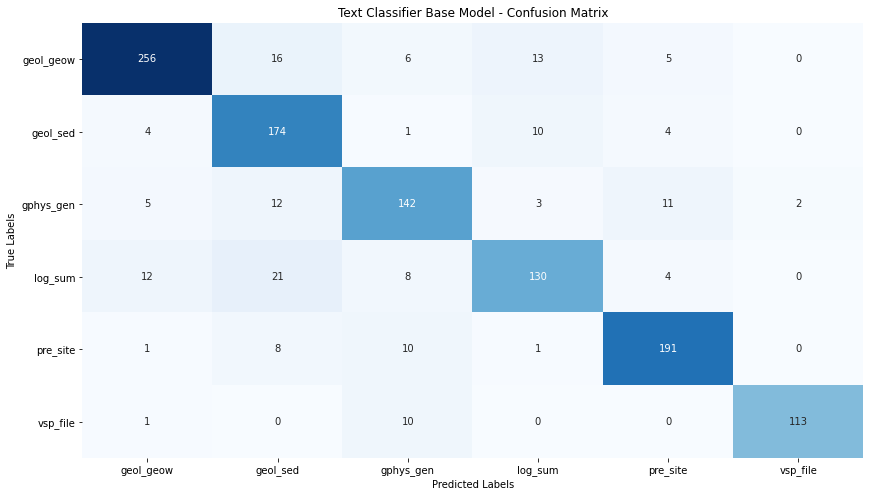

In [79]:
model_utils.confusion_matrix(y, y_hat, label_map, 'Text Classifier Base Model')

In [80]:
labels = [label for label in label_map]
print(metrics.classification_report(y, y_hat, target_names=labels))

              precision    recall  f1-score   support

   geol_geow       0.92      0.86      0.89       296
    geol_sed       0.75      0.90      0.82       193
   gphys_gen       0.80      0.81      0.81       175
     log_sum       0.83      0.74      0.78       175
    pre_site       0.89      0.91      0.90       211
    vsp_file       0.98      0.91      0.95       124

    accuracy                           0.86      1174
   macro avg       0.86      0.86      0.86      1174
weighted avg       0.86      0.86      0.86      1174



In [7]:
metric_averages = model_utils.iterate_training(
    models.text_cnn_model, 
    doc_data, 
    10, 
    y,
    'text',
    model_params={
        'doc_data': doc_data,
        'kernel_size': 7,
        'filter_maps': 200,
        'dense_layers': 1,
        'dense_nodes': 50,
        'dropout_rate': 0.3,
        'l2_regularization': 0.5
    }
)

---- Training model iteration 0:
Epoch 1/100
118/118 - 29s - loss: 4.6855 - accuracy: 0.4556 - val_loss: 2.6013 - val_accuracy: 0.7167
Epoch 2/100
118/118 - 28s - loss: 1.7501 - accuracy: 0.7716 - val_loss: 1.1622 - val_accuracy: 0.8094
Epoch 3/100
118/118 - 28s - loss: 0.7886 - accuracy: 0.8929 - val_loss: 0.7020 - val_accuracy: 0.8477
Epoch 4/100
118/118 - 28s - loss: 0.4194 - accuracy: 0.9472 - val_loss: 0.5559 - val_accuracy: 0.8690
Epoch 5/100
118/118 - 29s - loss: 0.2555 - accuracy: 0.9776 - val_loss: 0.5161 - val_accuracy: 0.8669
Epoch 6/100
118/118 - 30s - loss: 0.1735 - accuracy: 0.9896 - val_loss: 0.4929 - val_accuracy: 0.8701
Epoch 7/100
118/118 - 30s - loss: 0.1333 - accuracy: 0.9907 - val_loss: 0.4890 - val_accuracy: 0.8658
Epoch 8/100
118/118 - 30s - loss: 0.1053 - accuracy: 0.9931 - val_loss: 0.5035 - val_accuracy: 0.8637
Epoch 9/100
118/118 - 29s - loss: 0.0899 - accuracy: 0.9944 - val_loss: 0.4852 - val_accuracy: 0.8647
Epoch 10/100
118/118 - 29s - loss: 0.0790 - accur

In [8]:
metric_averages

{'ave_precision': 0.8632179226909538,
 'ave_recall': 0.8576660910496976,
 'ave_f1_score': 0.8586936137128814,
 'ave_accuracy': 0.8597104012966156,
 'ave_loss': 0.4666433721780777}